# CME predictor

In this prediction problem, we'll then ascribe each active region to one of two classes:

1. The positive class contains flaring active regions that did produce a CME. 

2. The negative class contains flaring active regions that did not produce a CME. 

To create our CME predictor we need to gather our training dataset: 

1. CME data from SOHO/LASCO and STEREO/SECCHI coronographs, which can be accessed from the `Database Of Notifications, Knowledge, Information` [DONKI database](http://kauai.ccmc.gsfc.nasa.gov/DONKI/). This tells us if an active region has produced a CME or not.

2. Flare data from the GOES flare catalog at NOAA, which can be accessed with the `sunkit_instruments` library, a SunPy affiliated package for solar instrument-specific tools. This tells us if an active region produced a flare or not.

3. Active region data from the Solar Dynamics Observatory's `Helioseismic and Magnetic Imager instrument` (HMI), which can be accessed from the [JSOC database](http://jsoc.stanford.edu/) via a JSON API. This gives us the features characterizing each active region `SHARP` – Space-Weather HMI Active Region Patches [Bobra et al., 2014](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3).

## Step 1: Gathering data for the positive class

First, we'll import some modules.

In [1]:
# General libraries
import numpy as np
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import pandas as pd
import scipy.stats
import requests
import urllib
import json
from datetime import datetime as dt_obj
from datetime import timedelta

# Machine learning libraries
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 50)

# Sunpy
try:
    import sunpy
    from sunpy.time import TimeRange
except ImportError:
    %pip install sunpy
    from sunpy.time import TimeRange

# Lime library
try:
    import lime
    import lime.lime_tabular
except ImportError:
    %pip install lime
    import lime
    import lime.lime_tabular
    
# Sunkit-instruments
try:
    import sunkit_instruments
except ImportError:
    %pip install sunkit_instruments
    import sunkit_instruments

Let's first query the [DONKI database](http://kauai.ccmc.gsfc.nasa.gov/DONKI/) to get the data associated with the positive class.

In [100]:
# request the data
t_start = "2010-05-01" # Using solar cycle 24
t_end = "2011-05-01"  # Date for example, but using until 2024 for the full dataset (takes ~30min)



baseurl = "https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/FLR?"

url = baseurl+"startDate="+t_start+"&endDate="+t_end
print('[INFO] requesting data from', url)

flag_for_fulldataset = False
print('[INFO] flag_for_fulldataset:', flag_for_fulldataset)



[INFO] requesting data from https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/FLR?startDate=2012-03-05&endDate=2012-03-07
[INFO] flag_for_fulldataset: False


In [101]:
# read the data
df = pd.read_json(url)

In [102]:
# Let's see the data
df

,flrID,instruments,beginTime,peakTime,endTime,classType,sourceLocation,activeRegionNum,linkedEvents,link
0,2012-03-05T03:30:00-FLR-001,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2012-03-05T03:30Z,2012-03-05T04:05Z,2012-03-05T04:43Z,X1.1,N19E58,11429.0,[{'activityID': '2012-03-05T04:00:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
1,2012-03-07T00:00:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2012-03-07T00:02Z,2012-03-07T00:24Z,2012-03-07T00:40Z,X5.4,N18E31,11429.0,[{'activityID': '2012-03-07T00:36:00-CME-001'}...,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
2,2012-03-07T01:05:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2012-03-07T01:05Z,2012-03-07T01:14Z,2012-03-07T01:23Z,X1.3,N17E27,NaN,[{'activityID': '2012-03-07T00:36:00-CME-001'}...,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...


In [105]:
# 1.- we will focus only on the strongest flares: M and X class
# 2.- we will drop the rows that aren't linked to CME events
events_list = df.loc[df['classType'].str.contains("M|X") & df['linkedEvents'].apply(lambda x: any('CME' in i['activityID'] for i in x) if x is not None else False)] # & df['activeRegionNum'].apply(lambda x: np.nan_to_num(x) > 0)]

# Drop the most of columns for a better visualization after the filtering
events_list = events_list.drop(columns=['flrID','linkedEvents','instruments','beginTime','endTime','link'])
events_list = events_list.reset_index(drop=True)



In [106]:
events_list

,peakTime,classType,sourceLocation,activeRegionNum
0,2012-03-05T04:05Z,X1.1,N19E58,11429.0
1,2012-03-07T00:24Z,X5.4,N18E31,11429.0
2,2012-03-07T01:14Z,X1.3,N17E27,NaN


In [107]:

len_events = events_list.shape[0]
print("There are", len_events, "events in the list")

There are 3 events in the list


Convert the `peakTime` column in the `events_list` dataframe from a string into a datetime object:

In [8]:
def parse_tai_string(tstr):
    year = int(tstr[:4])
    month = int(tstr[5:7])
    day = int(tstr[8:10])
    hour = int(tstr[11:13])
    minute = int(tstr[14:16])
    return dt_obj(year, month, day, hour, minute)


for i in range(events_list.shape[0]):
    events_list.loc[i, 'peakTime'] = parse_tai_string(events_list.loc[i, 'peakTime'])
    
    

We need to improve the data quality. We need to check 3 cases:
1. The DONKI database does not have the active region number.
2. The DONKI database has the active region number but it is not the correct one.
3. The DONKI database has the peak time of the flare but it is not the correct one.

Check for Case 1: In this case, the CME and flare exist but NOAA active region number does not exist in the DONKI database.

In [9]:
import sunkit_instruments.goes_xrs

# We will use the GOES flare database to find the missing NOAA active region numbers

number_of_donki_mistakes = 0  # count the number of DONKI mistakes

# Create a list to store the indices of the rows that will be dropped
event_list_drops = []
for i in range(events_list.shape[0]):
    
    # print(events_list.loc[i]['activeRegionNum'])
    # If the active region number is NaN, we will find the missing NOAA active region number
    if (np.isnan(events_list.loc[i]['activeRegionNum'])):
        time = events_list.loc[i]['peakTime']
        time_range = TimeRange(time, time)
        # A string specifying a minimum GOES class for inclusion in the list, e.g., “M1”, “X2”.
        listofresults =  sunkit_instruments.goes_xrs.get_goes_event_list(time_range, 'M1')
        
        if len(listofresults) < 0.5:
            # When sunkit fails to find any event that day
            print(time,events_list.loc[i]['classType'], "has no match in the GOES flare database ; dropping row.")
            event_list_drops.append(i)
            number_of_donki_mistakes += 1
            continue
        
        if (listofresults[0]['noaa_active_region'] == 0):
            print(time,events_list.loc[i]['activeRegionNum'], events_list.loc[i]
                  ['classType'], "has no match in the GOES flare database ; dropping row.")
            event_list_drops.append(i)
            number_of_donki_mistakes += 1
            continue
        else:
            print("Missing NOAA number:", events_list.loc[i]['activeRegionNum'], events_list.loc[i]['classType'],
                  events_list['peakTime'].iloc[i], "should be", listofresults[0]['noaa_active_region'], "; changing now.")
            events_list.loc[i, 'activeRegionNum'] = listofresults[0]['noaa_active_region']
            number_of_donki_mistakes += 1

# Drop the rows for which there is no active region number in both the DONKI and GOES flare databases
events_list = events_list.drop(event_list_drops)
events_list = events_list.reset_index(drop=True)
print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

There are 0 DONKI mistakes so far.


Now we grab all the data from the GOES database in preparation for checking Cases 2 and 3.

In [10]:
# Grab all the data from the GOES database
time_range = TimeRange(t_start, t_end)
listofresults = sunkit_instruments.goes_xrs.get_goes_event_list(time_range, 'M1')
print('Grabbed all the GOES data; there are', len(listofresults), 'events.')

Grabbed all the GOES data; there are 24 events.


Check for Case 2: In this case, the NOAA active region number is wrong in the DONKI database.

In [11]:
# Case 2: NOAA active region number is wrong in DONKI database

# collect all the peak flares times in the NOAA database
peak_times_noaa = [item["peak_time"] for item in listofresults]

for i in range(events_list.shape[0]):
    # check if a particular DONKI flare peak time is also in the NOAA database
    peak_time_donki = events_list['peakTime'].iloc[i]
    
    # If the peak time is in the NOAA database, we can compare the active region numbers!
    if peak_time_donki in peak_times_noaa:
        index = peak_times_noaa.index(peak_time_donki)
    else:
        continue
    
    # ignore NOAA active region numbers equal to zero
    if (listofresults[index]['noaa_active_region'] == 0):
        continue
    
    # if yes, check if the DONKI and NOAA active region numbers match up for this peak time
    # if they don't, flag this peak time and replace the DONKI number with the NOAA number
    if (listofresults[index]['noaa_active_region'] != int(events_list['activeRegionNum'].iloc[i])):
        print('Messed up NOAA number:', int(events_list['activeRegionNum'].iloc[i]), events_list['classType'].iloc[i],
              events_list['peakTime'].iloc[i], "should be", listofresults[index]['noaa_active_region'], "; changing now.")
        events_list.loc[i, 'activeRegionNum'] = listofresults[index]['noaa_active_region']
        number_of_donki_mistakes += 1
print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

There are 0 DONKI mistakes so far.


Check for Case 3: In this case, the flare peak time is wrong in the DONKI database.

In [12]:
# Case 3: The flare peak time is wrong in the DONKI database.

# create an empty array to hold row numbers to drop at the end
event_list_drops = []

active_region_numbers_noaa = [item["noaa_active_region"]
                              for item in listofresults]
flare_classes_noaa = [item["goes_class"] for item in listofresults]

for i in range(events_list.shape[0]):
    
    # check if a particular DONKI flare peak time is also in the NOAA database
    peak_time_donki = events_list['peakTime'].iloc[i]
    
    # If the peak time is not in the NOAA database, let's try to fix it
    if not peak_time_donki in peak_times_noaa:
        
        active_region_number_donki = int(events_list.loc[i,'activeRegionNum'])
        
        flare_class_donki = events_list['classType'].iloc[i]
        
        # List of flares with the same name
        flare_class_indices = [i for i, x in enumerate(
            flare_classes_noaa) if x == flare_class_donki]
        
        # List of active regions with the same number
        active_region_indices = [i for i, x in enumerate(
            active_region_numbers_noaa) if x == active_region_number_donki]
        
        # Index of the common elements in the two lists
        common_indices = list(
            set(flare_class_indices).intersection(active_region_indices))
        
        # This common index is the index of the flare in the NOAA database
        # which has the same active region number and flare class as the DONKI database
        
        if common_indices:
            print("Messed up time:", int(events_list['activeRegionNum'].iloc[i]), events_list.loc[i,'classType'],
                  events_list.loc[i,'peakTime'], "should be", peak_times_noaa[common_indices[0]], "; changing now.")
            events_list.loc[i, 'peakTime'] = peak_times_noaa[common_indices[0]]
            number_of_donki_mistakes += 1
            
        if not common_indices:
            print("DONKI flare peak time",
                  events_list.loc[i, 'peakTime'], "has no match; dropping row.")
            event_list_drops.append(i)
            number_of_donki_mistakes += 1

# Drop the rows for which the NOAA active region number and flare class associated with
# the messed-up flare peak time in the DONKI database has no match in the GOES flare database
events_list = events_list.drop(event_list_drops)
events_list = events_list.reset_index(drop=True)

# Create a list of corrected flare peak times
peak_times_donki = [events_list.loc[i, 'peakTime']
                    for i in range(events_list.shape[0])]


print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

There are 0 DONKI mistakes so far.


This is our final table of events that fall into the positive class:

In [13]:
events_list

,peakTime,classType,sourceLocation,activeRegionNum
0,2011-02-15 01:56:00,X2.2,S20W10,11158
1,2011-02-24 07:35:00,M3.5,N14E87,11163


Now let's query the JSOC database to see if there are active region parameters at the time of the flare. First read the following file to map NOAA active region numbers to HARPNUMs (a HARP, or an HMI Active Region Patch, is the preferred numbering system for the HMI active regions as they appear in the magnetic field data before NOAA observes them in white light):

In [14]:
answer = pd.read_csv(
    'http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt', sep=' ')

Now, let's determine at which time we'd like to predict CMEs. In general, many people try to predict a CME either 24 or 48 hours before it happens. We can report both in this study by setting a variable called `timedelayvariable`:

In [15]:
timedelayvariable = 24

Now, we'll convert subtract `timedelayvariable` from the GOES Peak Time and re-format the datetime object into a string that JSOC can understand:

In [16]:
t_rec = [(events_list['peakTime'].iloc[i] - timedelta(hours=timedelayvariable)
          ).strftime('%Y.%m.%d_%H:%M_TAI') for i in range(events_list.shape[0])]

Now we can grab the SDO data from the JSOC database by executing the JSON queries. The SHARP parameters are calculated every 12 minutes during an AR lifetime. We are selecting data that satisfies several criteria: The data has to be [1] disambiguated with a version of the disambiguation module greater than 1.1, [2] taken while the orbital velocity of the spacecraft is less than 3500 m/s, [3] of a high quality, and [4] within 70 degrees of central meridian. If the data pass all these tests, they are put into one of two lists: one for the positive class (called CME_data) and one for the negative class (called no_CME_data).

In [17]:
def get_the_jsoc_data(event_count, t_rec):
    """
    Parameters
    ----------
    event_count: number of events 
                 int

    t_rec:       list of times, one associated with each event in event_count
                 list of strings in JSOC format ('%Y.%m.%d_%H:%M_TAI')

    """

    catalog_data = []
    classification = []

    for i in range(event_count):

        print("=====", i,"/",event_count-1,"=====")
        
        # Check if the active region number is not zero:
        if int(listofactiveregions[i]) == 0:
            print('skip: NOAA Active Region number is zero')
            continue
        
        # next match NOAA_ARS to HARPNUM
        idx = answer[answer['NOAA_ARS'].str.contains(
            str(int(listofactiveregions[i])))]

        # if there's no HARPNUM, quit
        if (idx.empty == True):
            print('skip: there are no matching HARPNUMs for',
                  str(int(listofactiveregions[i])))
            continue

        # construct jsoc_info queries and query jsoc database; we are querying for 25 keywords
        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_720s["+str(
            idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (CODEVER7 !~ '1.1 ') and (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,MEANJZD,TOTUSJZ,SAVNCPP,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH"
        response = requests.get(url)

        # if there's no response at this time, quit
        if response.status_code != 200:
            print('skip: cannot successfully get an http response')
            continue

        # read the JSON output
        data = response.json()

        # if there are no data at this time, quit
        if data['count'] == 0:
            print('skip: there are no data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        # check to see if the active region is too close to the limb
        # we can compute the latitude of an active region in stonyhurst coordinates as follows:
        # latitude_stonyhurst = CRVAL1 - CRLN_OBS
        # for this we have to query the CEA series (but above we queried the other series as the CEA series does not have CODEVER5 in it)

        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s["+str(
            idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=CRVAL1,CRLN_OBS"
        response = requests.get(url)

        # if there's no response at this time, quit
        if response.status_code != 200:
            print('skip: failed to find CEA JSOC data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        # read the JSON output
        latitude_information = response.json()

        # if there are no data at this time, quit
        if latitude_information['count'] == 0:
            print('skip: there are no data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        CRVAL1 = float(latitude_information['keywords'][0]['values'][0])
        CRLN_OBS = float(latitude_information['keywords'][1]['values'][0])
        if (np.absolute(CRVAL1 - CRLN_OBS) > 70.0):
            print('skip: latitude is out of range for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        if ('MISSING' in str(data['keywords'])):
            print('skip: there are some missing keywords for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        print('accept NOAA Active Region number', str(int(
            listofactiveregions[i])), 'and HARPNUM', idx.HARPNUM.values[0], 'at time', t_rec[i])

        individual_flare_data = []
        for j in range(18):
            individual_flare_data.append(
                float(data['keywords'][j]['values'][0]))

        catalog_data.append(list(individual_flare_data))

        single_class_instance = [idx.HARPNUM.values[0], str(
            int(listofactiveregions[i])), listofgoesclasses[i], t_rec[i]]
        classification.append(single_class_instance)

    return catalog_data, classification

Now we prepare the data to be fed into the function:

In [18]:
listofactiveregions = list(events_list['activeRegionNum'].values.flatten())
listofgoesclasses = list(events_list['classType'].values.flatten())

And call the function:

In [19]:
# get the data
CME_data, positive_class = get_the_jsoc_data(events_list.shape[0], t_rec)

# save the data
if flag_for_fulldataset:
    np.save('CME_data_full.npy', CME_data)
    np.save('positive_class_full.npy', positive_class)

    


===== 0 / 1 =====
accept NOAA Active Region number 11158 and HARPNUM 377 at time 2011.02.14_01:56_TAI
===== 1 / 1 =====
skip: there are no data for HARPNUM 392 at time 2011.02.23_07:35_TAI


Here is the number of events associated with the positive class:

In [20]:
print("There are", len(CME_data), "CME events in the positive class.")

There are 1 CME events in the positive class.


## Step 2: Gathering data for the negative class

To gather the examples for the negative class, we only need to:

1. Query the GOES database for all the M- and X-class flares during our time of interest, and
2. Select the ones that are not associated with a CME. 

In [21]:
# select peak times that belong to both classes
all_peak_times = np.array([(listofresults[i]['peak_time'])
                           for i in range(len(listofresults))])

negative_class_possibilities = []
counter_positive = 0
counter_negative = 0
for i in range(len(listofresults)):
    this_peak_time = all_peak_times[i]
    if (this_peak_time in peak_times_donki):
        counter_positive += 1
    else:
        counter_negative += 1
        this_instance = [listofresults[i]['noaa_active_region'],
                         listofresults[i]['goes_class'], listofresults[i]['peak_time']]
        negative_class_possibilities.append(this_instance)
print("There are", counter_positive, "events in the positive class.")
print("There are", counter_negative, "events in the negative class.")

There are 2 events in the positive class.
There are 22 events in the negative class.


Again, we compute times that are one day before the flare peak time and convert it into a string that JSOC can understand:

In [22]:
t_rec = np.array([(negative_class_possibilities[i][2] - timedelta(hours=timedelayvariable)
                   ).strftime('%Y.%m.%d_%H:%M_TAI') for i in range(len(negative_class_possibilities))])

And again, we query the JSOC database to see if these data are present:

In [23]:
listofactiveregions = list(
    negative_class_possibilities[i][0] for i in range(counter_negative))
listofgoesclasses = list(
    negative_class_possibilities[i][1] for i in range(counter_negative))

In [24]:
# retrieve the data and save the data
if flag_for_fulldataset:
    no_CME_data, negative_class = get_the_jsoc_data(counter_negative, t_rec)

    np.save('no_CME_data_full.npy', no_CME_data)
    np.save('negative_class_full.npy', negative_class)



Here is the number of events associated with the negative class:

In [25]:
# retrieve the data and save the data
if flag_for_fulldataset:
    print("There are", len(no_CME_data), "no-CME events in the negative class.")

Some of the features within a data set may be powerful for distinguishing between the positive and negative class, whereas others may be redundant or irrelevant. To identify features in the former category, we use a univariate feature selection method, which is implemented in the feature selection module of the scikit-learn library, for feature scoring.

To improve the performance of the feature selection algorithm, we'll normalize each feature so that they lie within similar ranges. To do this, we subtract from every feature its median value and divide by its standard deviation.

## Load the full dataset

In [26]:
# Normalize the data
def normalize_together(positive_class, negative_class):
    both_classes = np.concatenate((positive_class, negative_class), axis=0)
    for j in range(both_classes.shape[1]):
        standard_deviation_of_this_feature = np.std(both_classes[:, j])
        median_of_this_feature = np.median(both_classes[:, j])
        for i in range(positive_class.shape[0]):
            positive_class[i, j] = (
                positive_class[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
        for i in range(negative_class.shape[0]):
            negative_class[i, j] = (
                negative_class[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
    return positive_class, negative_class


In [93]:

prepare_student_data = True
if prepare_student_data:

    CME_data = np.load('cme_cycle24+/CME_data_full.npy')
    positive_class = np.load('cme_cycle24+/positive_class_full.npy')

    no_CME_data = np.load('cme_cycle24+/no_CME_data_full.npy')
    negative_class = np.load('cme_cycle24+/negative_class_full.npy')
    
    no_CME_data, CME_data = normalize_together(no_CME_data, CME_data)
        
    # Note: Extract 50 events and their corresponding features for testing later:
    index_positive = np.random.choice(range(len(positive_class)), 50, replace=False)
    index_negative = np.random.choice(range(len(negative_class)), 0, replace=False)
    
    # Extract the features and metadata for the selected events, and delete them from the full dataset
    selected_features = np.concatenate((CME_data[index_positive], no_CME_data[index_negative]), axis=0)
    selected_metadata = np.concatenate((positive_class[index_positive], negative_class[index_negative]), axis=0)
    
    # Shuffle the selected features and metadata to ensure they are mixed
    # shuffle_index = np.random.permutation(len(selected_features))
    # selected_features = selected_features[shuffle_index]
    # selected_metadata = selected_metadata[shuffle_index]
    
    # Save the selected features and metadata
    np.save('cme_cycle24+/student_target_features.npy', selected_features)
    np.save('cme_cycle24+/student_target_metadata.npy', selected_metadata)
    
    # remove the selected features from the full dataset
    CME_data = np.delete(CME_data, index_positive, axis=0)
    no_CME_data = np.delete(no_CME_data, index_negative, axis=0)
    positive_class = np.delete(positive_class, index_positive, axis=0)
    negative_class = np.delete(negative_class, index_negative, axis=0)
    
    # Save the new datasets
    np.save('cme_cycle24+/CME_data_.npy', CME_data)
    np.save('cme_cycle24+/positive_class_.npy', positive_class)
    np.save('cme_cycle24+/no_CME_data_.npy', no_CME_data)
    np.save('cme_cycle24+/negative_class_.npy', negative_class)

    
else:
    # Load the selected features and metadata
    selected_features = np.load('cme_cycle24+/student_target_features.npy')
    selected_metadata = np.load('cme_cycle24+/student_target_metadata.npy')
    
    # Load the training dataset
    CME_data = np.load('cme_cycle24+/CME_data_.npy')
    positive_class = np.load('cme_cycle24+/positive_class_.npy')
    no_CME_data = np.load('cme_cycle24+/no_CME_data_.npy')
    negative_class = np.load('cme_cycle24+/negative_class_.npy')
    
    # # Load the training dataset
    # CME_data = np.load('cme_cycle24+/CME_data_full.npy')
    # positive_class = np.load('cme_cycle24+/positive_class_full.npy')
    # no_CME_data = np.load('cme_cycle24+/no_CME_data_full.npy')
    # negative_class = np.load('cme_cycle24+/negative_class_full.npy')
    
    # no_CME_data, CME_data = normalize_together(no_CME_data, CME_data)

    print("There are", no_CME_data.shape[0], "flares with no associated CMEs.")
    print("There are", CME_data.shape[0], "flares with associated CMEs.")

In [28]:
# # Download new dataset from:
# dataset= 'https://github.com/JasonTLWang/RNN-CME-prediction/blob/master/CME_data_samples/normalized_testing_24.csv'
# df = pd.read_csv('cycle24/normalized_testing_24.csv')


In [29]:
# Summary of the data
print("Number of features:", len(CME_data[0]))

# positive class
print("Positive class:")
print("Number of events:", len(CME_data))

# negative class
print("Negative class:")
print("Number of events:", len(no_CME_data))

# Ratio: negative class to positive class
ratio = len(no_CME_data)/len(CME_data)
print("Ratio of negative class to positive class:", ratio)


Number of features: 18
Positive class:
Number of events: 175
Negative class:
Number of events: 441
Ratio of negative class to positive class: 2.52


We will later investigate another way to get a balanced dataset. We will use the `imbalanced-learn` library to generate synthetic samples of the minority class and see the impact on the performance of the classifier.

In [30]:
run_smote = False
if run_smote:

    from imblearn.over_sampling import SMOTE

    # Apply the SMOTE algorithm to balance the dataset
    sm = SMOTE(random_state=42)

    xsample = np.concatenate((CME_data, no_CME_data), axis=0)
    ysample = np.concatenate((np.ones(len(CME_data)), np.zeros(len(no_CME_data))))

    xresampled, yresampled = sm.fit_resample(xsample, ysample)

    # Summary of the data
    print("Number of features:", len(xresampled[0]))
    print("Number of events:", len(xresampled[yresampled == 1]))
    print("Number of no events:", len(xresampled[yresampled == 0]))


    CME_data = xresampled[yresampled == 1]
    no_CME_data = xresampled[yresampled == 0]

## Step 3: Feature selection (filter methods)

An important step before starting to use any predictive method is to study the information present in the data. To do this, we are going to study the distribution of the characteristics of the active regions that produced a CME and those that did not. We will see the distribution of a feature for the active regions that produced a CME (green) and for the active regions that did not produce a CME (red). You can change the value of `i` in the code block below to see that some features are not at all useful since there is hardly any difference in the distributions for the positive and negative class. Therefore, we could discard those features from our sample before starting the modeling.

This exercise is commonly referred to as Feature filtering and is based on the statistical properties of the features, such as correlation, variance, etc. These methods are fast and scalable, but do not consider the interactions between features or the predictive power of the subset of features. Other feature selection methods will be discussed later.

In [31]:
sharps = ['Total unsigned flux', 'Mean gradient of total field',
          'Mean current helicity (Bz contribution)', 'Mean photospheric magnetic free energy',
          'Fraction of Area with Shear > 45 deg', 'Total unsigned current helicity',
          'Mean gradient of horizontal field', 'Mean characteristic twist parameter, alpha',
          'Mean angle of field from radial', 'Mean gradient of vertical field',
          'Mean vertical current density', 'Total unsigned vertical current',
          'Sum of the modulus of the net current per polarity',
          'Total photospheric magnetic free energy density', 'Mean shear angle',
          'Area of strong field pixels in the active region', 'Sum of flux near polarity inversion line',
          'Absolute value of the net current helicity']

sharp_mini = ['USFLUX', 'MEANGBT', 'MEANJZH', 'MEANPOT', 'SHRGT45', 'TOTUSJH', 'MEANGBH', 'MEANALP', 'MEANGAM', 'MEANGBZ', 'MEANJZD', 'TOTUSJZ', 'SAVNCPP', 'TOTPOT', 'MEANSHR', 'AREA_ACR', 'R_VALUE', 'ABSNJZH']


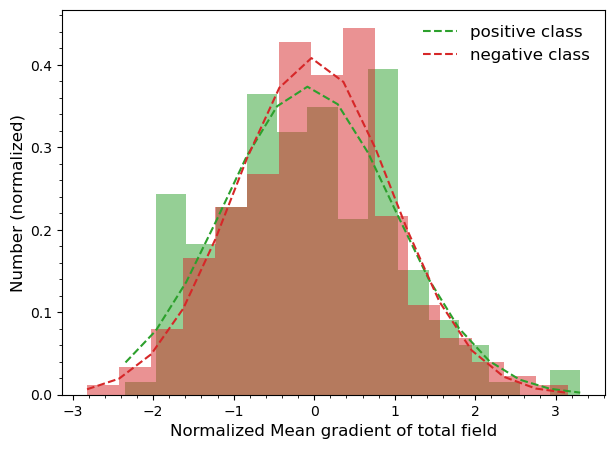

In [32]:
i = 1

plt.figure(figsize=(7, 5))

# For the positive class (green)
mu_fl = np.mean(CME_data[:, i])
sigma_fl = np.std(CME_data[:, i])
num_bins = 15
n_fl, bins_fl, patches_fl = plt.hist(CME_data[:, i], num_bins, facecolor='C2', alpha=0.5,density=True)
y_fl = scipy.stats.norm.pdf(bins_fl, mu_fl, sigma_fl)
plt.plot(bins_fl, y_fl, 'C2--', label='positive class')

# For the negative class (red)
mu_nofl = np.mean(no_CME_data[:, i])
sigma_nofl = np.std(no_CME_data[:, i])
n_nofl, bins_nofl, patches_nofl = plt.hist(no_CME_data[:, i], num_bins, facecolor='C3', alpha=0.5,density=True)
y_nofl = scipy.stats.norm.pdf(bins_nofl, mu_nofl, sigma_nofl)
plt.plot(bins_nofl, y_nofl, 'C3--', label='negative class')

plt.xlabel('Normalized '+sharps[i], fontsize=12)
plt.ylabel('Number (normalized)', fontsize=12)
plt.minorticks_on()
plt.locator_params(axis='y', nbins=6)
legend = plt.legend(loc='upper right', fontsize=12, framealpha=0.0, title='')
plt.savefig('figures/feature_'+str(i)+'.png', dpi=300, bbox_inches='tight')


Now we will compute the Univariate F-score for feature selection. It is a very simple method: the F-score measures the distance between the two distributions for a given feature (inter-class distance), divided by the sum of the variances for this feature (intra-class distance). We can use the `sklearn.feature_selection` module to do this:

In [33]:
# import the feature selection method
from sklearn.feature_selection import SelectKBest, f_classif
# select the number of features
N_features = CME_data.shape[1]
Nfl = CME_data.shape[0]
Nnofl = no_CME_data.shape[0]
yfl = np.ones(Nfl)
ynofl = np.zeros(Nnofl)
# k is the number of features
selector = SelectKBest(f_classif, k=N_features)
selector.fit(np.concatenate((CME_data, no_CME_data), axis=0),
             np.concatenate((yfl, ynofl), axis=0))
scores = selector.scores_


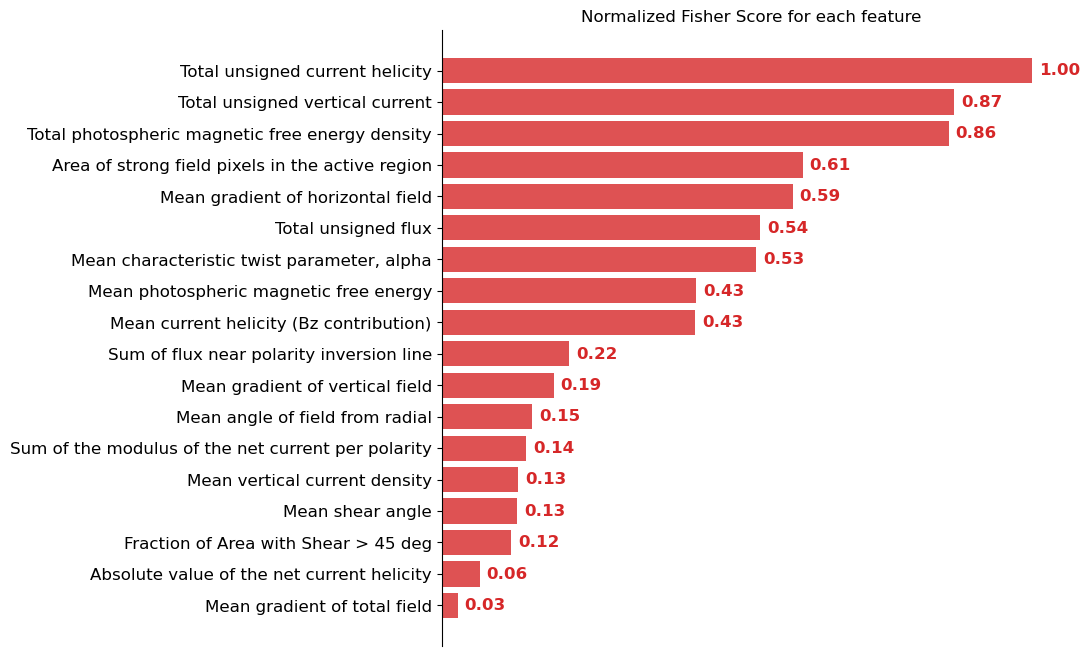

In [34]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(8, 8))
order = np.argsort(selector.scores_)
orderedsharps = [sharps[i] for i in order]
orderedscores = [selector.scores_[i]/np.max(selector.scores_) for i in order]
y_pos2 = np.arange(18)
bars = plt.barh(y_pos2, orderedscores, color='C3', alpha=0.8, height=0.8)
plt.yticks(y_pos2, orderedsharps, fontsize=12)
plt.xlabel('Normalized Fisher Score', fontsize=12)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

def custom_fmt(x):
    return '<0.01' if x < 0.01 else '%.2f' % x

ax.bar_label(bars, padding=+5, color='C3', 
             fontsize=12, label_type='edge', fmt=custom_fmt,
             fontweight='bold')
# Add title:
plt.title('Normalized Fisher Score for each feature')
plt.savefig('figures/Fisher_score.png', dpi=300, bbox_inches='tight')

## Step 4: The support vector machine

Now we initialize the support vector machine on the data. The SVM uses non-linear decision functions to map the feature space into a higher-dimensional space, where the positive and negative examples can be separated linearly by a hyperplane. <br>

This is incredibly non-intuitive. But we can think of a simpler example. Suppose we had two classes: CME-producing and non-CME producing active regions. And suppose we had two features: the total flux in these regions, and the total area of these regions. We could construct a two-dimentional feature space, where we plot the flux against the area of each active region. Positive examples could be indicated by an X and negatives ones by an O. In theory, if our data behaved well, we could draw a line between these classess. <br>

Since we have 18 features, the SVM constructs an 18-dimensional feature space. In this feature space, the decision boundary separating the positive and negative examples may be non-linear. As such, the algorithm then enlarges this 18-dimensional feature space (using the function indicated by the `kernel` parameter in the [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) function) into a higher-dimensional feature space wherein it is possible to linearly separate the positive and negatives classes. There are lots of people trying to work on how to [visualize these multi-dimensional feature spaces](https://github.com/tmadl/highdimensional-decision-boundary-plot), which is an active area of research.

In [35]:
number_of_examples = Nfl + Nnofl


C = 1e-0
gamma = 1e-1
clf = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced',
              cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)


## Step 5: Stratified k-folds cross-validation

Now we run and evaluate the performance of the SVM. There are lots of different ways to evaluate the performance of a classifier, which we discuss in Section 4 of [Bobra & Couvidat (2015)](https://arxiv.org/abs/1411.1405). We're going to choose a metric called the True Skill Score, or the TSS, which we can calculate from four quantities: true positives, true negatives, false positives, and false negatives. We prefer the TSS to all the other metrics as it is insensitive to the class imbalance ratio and thus best for comparison to other groups. The TSS is symmetrically distributed about 0: i.e., it goes from [-1, 1] where 0 represents no skill and a negative value represents a perverse prediction. Thus we are able to predict CMEs in a fashion better than randomly guessing. Here we define a confusion table to measure the performance of our binary classification: <br>

In [36]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

Now we run the SVM on our data and cross-validate our results. In our case, the positive sample size is quite small (both objectively and compared to the negative sample size). Therefore, we use a stratified k-folds cross-validation method, which makes k partitions of the data set and uses k-1 folds for training the SVM and 1 fold for testing the trained SVM. The stratification preserves the ratio of positive to negative examples per fold. Then we can permute over the partitions such that each partition eventually makes its way into the testing set. For each individual testing set, we can calculate a skill score. Then we can average the skill scores over the total number of testing sets. 

To compute the TSS, we must first select a value of k. k can be arbitrarily defined and take any value between 2 and `number_of_examples`, so we can explore this parameter space. As k approaches `number_of_examples`, the k-fold method reduces to the Leave One Out method, in which only one example is in the testing set and all other examples are in the training set. The literature suggests this method is not the best, so we can stray away from high values of k. Many studies (e.g. [Kohavi, 1995](http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf)) recommend the stratified 10-fold cross-validation to reduce variance and bias. Here, we test their recommendation by computing the TSS using 30 k values, ranging from 2 to 32. 

Now we can plot the mean TSS per k, using the standard deviation as the error in the TSS. We see that for high values of k, the standard deviation in the TSS can be greater than the mean. These points are indicated in blue.

As such, we confirm that high k-values result in a high variance. We find it reasonable to use the stratified 10-fold cross-validation method to compute the TSS and will follow this recommendation. Therefore we report this score as our final result:

In [37]:
# lists to hold the TSS and standard deviation of the TSS


# xdata are the examples
# ydata are the labels
xdata = np.concatenate((CME_data, no_CME_data), axis=0)
ydata = np.concatenate((np.ones(Nfl), np.zeros(Nnofl)), axis=0)
mdata = np.concatenate((positive_class, negative_class), axis=0)

# # # Create fake dataset:
# shuffle_index = np.random.permutation(ydata.shape[0])
# ydata = ydata[shuffle_index]


k = 4 # 25% of the data is used for testing
# skf = StratifiedKFold(n_splits=k, shuffle=True)
from sklearn.model_selection import RepeatedStratifiedKFold
skf = RepeatedStratifiedKFold(n_splits=k, n_repeats=10)
these_TSS_for_this_k = []
confusion_matrix_k = []
for train_index, test_index in skf.split(xdata, ydata):
    # xtrain are the examples in the training set
    xtrain = xdata[train_index]
    # ytrain are the labels in the training set
    ytrain = ydata[train_index]
    # xtest are the examples in the testing set
    xtest = xdata[test_index]
    # ytest are the labels in the testing set
    ytest = ydata[test_index]    
    # # metadata useful for interpreting with LIME
    # mtrain = mdata[train_index]
    # # metadata useful for interpreting with LIME
    # mtest = mdata[test_index]
    clf.fit(xtrain, ytrain)
    TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
    if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
        these_TSS_for_this_k.append(np.nan)
        continue
    else:
        these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
        confusion_matrix_k.append([TN, FP, TP, FN])
    # break
confusion_matrix_ = np.mean(confusion_matrix_k, axis=0)
TSS_k = np.array(these_TSS_for_this_k)

print(confusion_matrix_)

[71.575 38.675 26.45  17.3  ]


In [38]:
TN, FP, TP, FN = confusion_matrix_
confusion_matrix = np.array([TP, FN, FP, TN]).reshape(2, 2)
print(TP/(TP+FN) - FP/(FP+TN))

0.25377777777777777


<Figure size 800x800 with 0 Axes>

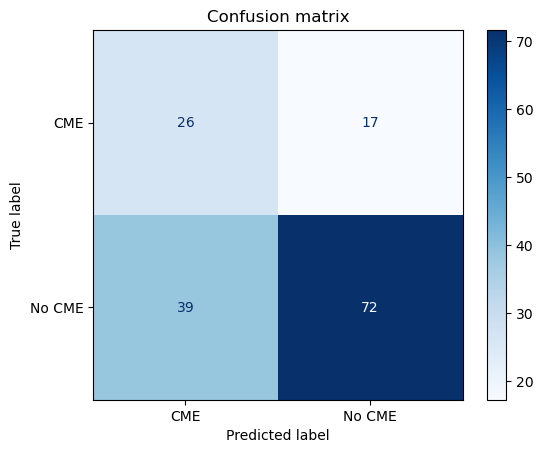

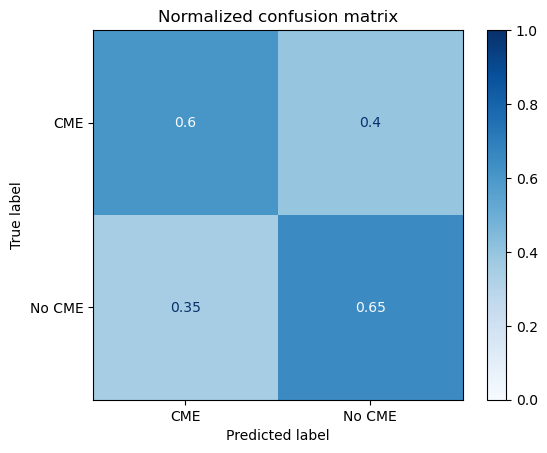

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 8))
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['CME','No CME'])
display.plot(cmap='Blues')
plt.title('Confusion matrix')

# Now normalize the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix= (confusion_matrix.T / np.sum(confusion_matrix,axis=1)).T, display_labels=['CME','No CME'])
display.plot(cmap='Blues')
plt.title('Normalized confusion matrix')
for im in plt.gca().get_images():                   # set clim manually within the image
    im.set_clim(vmin=0,vmax=1) 
plt.savefig('figures/confusion_matrix.png', dpi=300, bbox_inches='tight')

# Hyperparameter tuning:


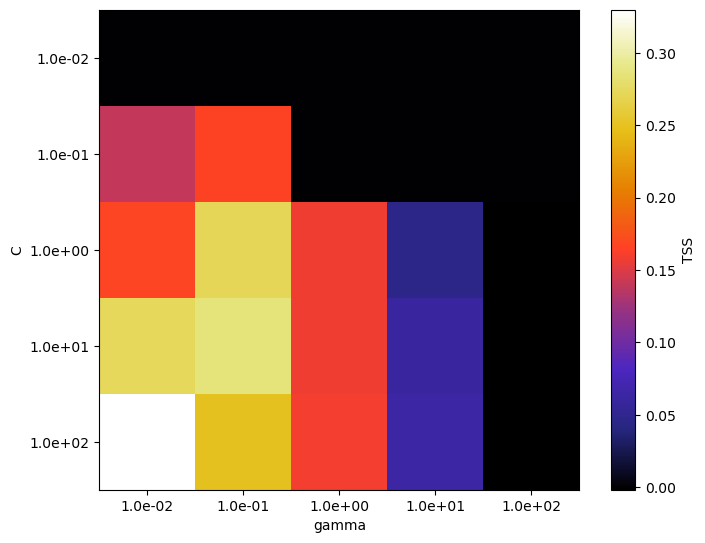

In [40]:
# TSS
TSS_tun_list = []

# Train the model
param_grid = {'C': 10**np.arange(-2, 3, 1.0),
              'gamma': 10**np.arange(-2, 3, 1.0)}

# skf = StratifiedKFold(n_splits=4, shuffle=True)
skf = RepeatedStratifiedKFold(n_splits=4, n_repeats=5)
for CC in param_grid['C']:
    for GG in param_grid['gamma']:
        clf = svm.SVC(C=CC, gamma=GG, kernel='rbf', class_weight='balanced',
                      cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)
        these_TSS_for_this_k = []
        for train_index, test_index in skf.split(xdata, ydata):
            xtrain = xdata[train_index]
            ytrain = ydata[train_index]
            xtest = xdata[test_index]
            ytest = ydata[test_index]
            clf.fit(xtrain, ytrain)
            TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
            if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
                these_TSS_for_this_k.append(np.nan)
                continue
            else:
                these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
        TSS_k = np.array(these_TSS_for_this_k)
        TSS_tun_list.append(np.mean(TSS_k))

TSS_tuned = np.array(TSS_tun_list).reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(TSS_tuned, interpolation='nearest', cmap='CMRmap',vmin=None, vmax=None)
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(param_grid['gamma'])), ['%.1e' % i for i in param_grid['gamma']])
plt.yticks(np.arange(len(param_grid['C'])), ['%.1e' % i for i in param_grid['C']])
cb = plt.colorbar()
cb.set_label('TSS')
plt.savefig('figures/TSS_tuned.png', dpi=300, bbox_inches='tight')

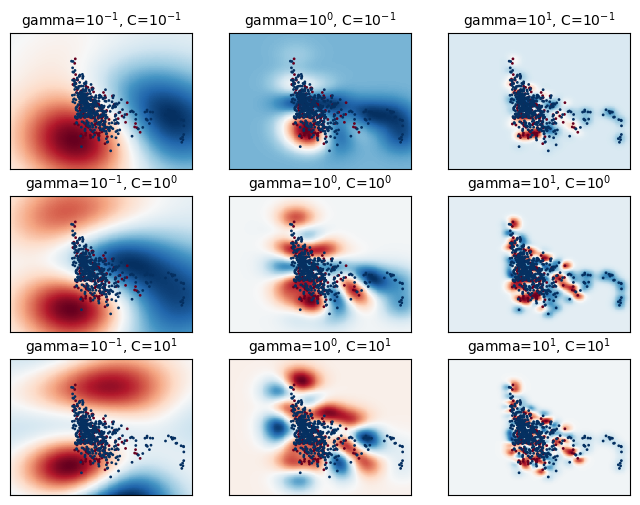

In [41]:
C_2d_range = [1e-1, 1, 1e1]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf_ = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced',
                cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)
        clf_.fit(xdata[:, :2], ydata)
        classifiers.append((C, gamma, clf_))
        

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-4, 5, 200), np.linspace(-4, 5, 200))
for k, (C, gamma, clf_) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf_.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title(r"gamma=$10^{%d}$, C=$10^{%d}$" % (np.log10(gamma), np.log10(C)), size="medium")

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(xdata[:, 0], xdata[:, 1], c=ydata, cmap=plt.cm.RdBu_r, s=1)
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")



# Step 6: Feature selection (wrapper methods)

We have seen that the model can predict CMEs with a high TSS using all the features, but we have seen that some features are not very helpful in distinguishing between the positive and negative classes. The Uni-variate Fisher Score tells us how much each feature contributes to the prediction alone, but two features might contain the same information or two with a low score might be very informative together. 

In this section we will analyze the importance of the features in the model with a wrapper method. A wrapper method evaluate the quality of the feature subset. Wrapper methods are more computationally expensive than filter methods, but they can capture the interactions between the features and the target variable, and select the optimal feature subset for a specific model.

In this section we will use a Recursive Feature Addition algorithm. This algorithm adds features one by one and checks the TSS. We will add the feature which increases the TSS the most. This strategy does not guarantee always the best solution (as we are not checking all possible combinations), but it is fast and gives good results.

In [42]:
# Best combination of C and gamma
# Note regarding SVM: C is the regularization parameter, being lower helps with overfitting (and converges faster)
# so for the same TSS, we should choose the lowest C (it will generalize better).

best_C = 1e0
best_gamma = 1e-0
print("The best combination of C and gamma is", best_C, "and", best_gamma)


clf = svm.SVC(C=best_C, gamma=best_gamma, kernel='rbf', class_weight='balanced',
                cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)

The best combination of C and gamma is 1.0 and 1.0


In [43]:

# Sequential feature selection: adding features one by one

total_features = CME_data.shape[1]

best_combination = []
TSS_for_best_combination = []
for combination in range(1, total_features+1):
    TSS_for_this_combination = []
    # features_to_use is the index saved in best_combination and the index of the feature we are testing
    for feature_to_test in range(total_features):
        if feature_to_test in best_combination:
            TSS_for_this_combination.append(0.0)
            continue
        features_to_use = best_combination.copy()
        features_to_use.append(feature_to_test)

        # skf = StratifiedKFold(n_splits=4, shuffle=True)
        skf = RepeatedStratifiedKFold(n_splits=4, n_repeats=2)
        these_TSS_for_this_k = []
        for train_index, test_index in skf.split(xdata, ydata):
            xtrain = xdata[train_index][:, features_to_use]
            ytrain = ydata[train_index]
            xtest = xdata[test_index][:, features_to_use]        
            # mtest = mdata[test_index]
            ytest = ydata[test_index]
            clf.fit(xtrain, ytrain)
            TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
            these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
        TSS = np.mean(these_TSS_for_this_k)
        
        TSS_for_this_combination.append(TSS)
    # print('All TSS for this combination:', TSS_for_this_combination)
    
    best_combination.append(np.argmax(TSS_for_this_combination))
    TSS_for_best_combination.append(np.max(TSS_for_this_combination))
    print("The best combination so far is", best_combination, "with a TSS of", "{:.2f}".format(np.max(TSS_for_this_combination)), 
          "where addition had a score of", "{:.2f}".format(selector.scores_[np.argmax(TSS_for_this_combination)]/np.max(selector.scores_)))

    # break
    
    

The best combination so far is [2] with a TSS of 0.21 where addition had a score of 0.43
The best combination so far is [2, 9] with a TSS of 0.24 where addition had a score of 0.19
The best combination so far is [2, 9, 0] with a TSS of 0.28 where addition had a score of 0.54
The best combination so far is [2, 9, 0, 11] with a TSS of 0.27 where addition had a score of 0.87
The best combination so far is [2, 9, 0, 11, 13] with a TSS of 0.26 where addition had a score of 0.86
The best combination so far is [2, 9, 0, 11, 13, 17] with a TSS of 0.27 where addition had a score of 0.06
The best combination so far is [2, 9, 0, 11, 13, 17, 15] with a TSS of 0.29 where addition had a score of 0.61
The best combination so far is [2, 9, 0, 11, 13, 17, 15, 4] with a TSS of 0.26 where addition had a score of 0.12
The best combination so far is [2, 9, 0, 11, 13, 17, 15, 4, 8] with a TSS of 0.27 where addition had a score of 0.15
The best combination so far is [2, 9, 0, 11, 13, 17, 15, 4, 8, 6] with a 

In [44]:
# Print the best combination of features with the names:
best_combination_names = [sharps[i] for i in best_combination]
for i in range(len(best_combination)):
    print("Feature", best_combination[i], ":", best_combination_names[i])

Feature 2 : Mean current helicity (Bz contribution)
Feature 9 : Mean gradient of vertical field
Feature 0 : Total unsigned flux
Feature 11 : Total unsigned vertical current
Feature 13 : Total photospheric magnetic free energy density
Feature 17 : Absolute value of the net current helicity
Feature 15 : Area of strong field pixels in the active region
Feature 4 : Fraction of Area with Shear > 45 deg
Feature 8 : Mean angle of field from radial
Feature 6 : Mean gradient of horizontal field
Feature 7 : Mean characteristic twist parameter, alpha
Feature 12 : Sum of the modulus of the net current per polarity
Feature 5 : Total unsigned current helicity
Feature 14 : Mean shear angle
Feature 1 : Mean gradient of total field
Feature 3 : Mean photospheric magnetic free energy
Feature 16 : Sum of flux near polarity inversion line
Feature 10 : Mean vertical current density


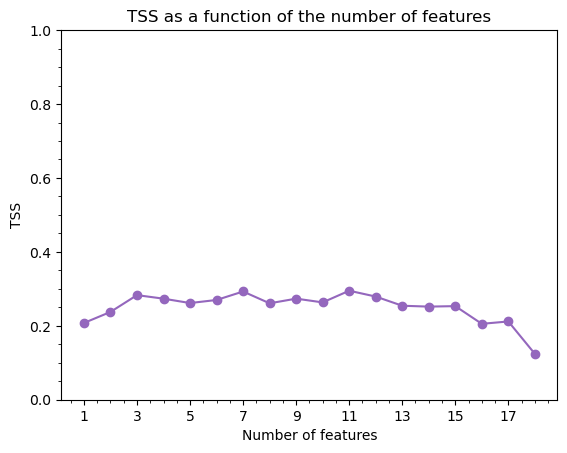

In [45]:
# An important trend we can already see is that as we start adding too many features, the TSS starts to decrease.
plt.plot(np.arange(1, total_features+1), TSS_for_best_combination, 'o-', color='C4')
plt.xlabel('Number of features')
plt.ylabel('TSS')
plt.title('TSS as a function of the number of features')
plt.xticks(np.arange(1, total_features+1))
plt.ylim(ymax=1.0, ymin=0)
plt.locator_params(axis='x', nbins=9)
plt.minorticks_on()
plt.savefig('figures/TSS_vs_number_of_features.png', dpi=300, bbox_inches='tight')

In [46]:
"""
k = 4 # 25% of the data is used for testing
# skf = StratifiedKFold(n_splits=k, shuffle=True)
from sklearn.model_selection import RepeatedStratifiedKFold
skf = RepeatedStratifiedKFold(n_splits=k, n_repeats=10)
these_TSS_for_this_k = []
confusion_matrix_k = []
for train_index, test_index in skf.split(xdata, ydata):
    # xtrain are the examples in the training set
    xtrain = xdata[train_index][:, [2, 9, 4, 15, 6, 16, 3, 10, 5, 17, 14, 12, 11, 7, 1, 0, 13]]
    # ytrain are the labels in the training set
    ytrain = ydata[train_index]
    # xtest are the examples in the testing set
    xtest = xdata[test_index][:, [2, 9, 4, 15, 6, 16, 3, 10, 5, 17, 14, 12, 11, 7, 1, 0, 13]]
    # ytest are the labels in the testing set
    ytest = ydata[test_index]    
    # # metadata useful for interpreting with LIME
    # mtrain = mdata[train_index]
    # # metadata useful for interpreting with LIME
    # mtest = mdata[test_index]
    clf.fit(xtrain, ytrain)
    TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
    if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
        these_TSS_for_this_k.append(np.nan)
        continue
    else:
        these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
        confusion_matrix_k.append([TN, FP, TP, FN])
    # break
confusion_matrix_ = np.mean(confusion_matrix_k, axis=0)
TSS_k = np.array(these_TSS_for_this_k)

print(np.mean(TSS_k))"""

'\nk = 4 # 25% of the data is used for testing\n# skf = StratifiedKFold(n_splits=k, shuffle=True)\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=10)\nthese_TSS_for_this_k = []\nconfusion_matrix_k = []\nfor train_index, test_index in skf.split(xdata, ydata):\n    # xtrain are the examples in the training set\n    xtrain = xdata[train_index][:, [2, 9, 4, 15, 6, 16, 3, 10, 5, 17, 14, 12, 11, 7, 1, 0, 13]]\n    # ytrain are the labels in the training set\n    ytrain = ydata[train_index]\n    # xtest are the examples in the testing set\n    xtest = xdata[test_index][:, [2, 9, 4, 15, 6, 16, 3, 10, 5, 17, 14, 12, 11, 7, 1, 0, 13]]\n    # ytest are the labels in the testing set\n    ytest = ydata[test_index]    \n    # # metadata useful for interpreting with LIME\n    # mtrain = mdata[train_index]\n    # # metadata useful for interpreting with LIME\n    # mtest = mdata[test_index]\n    clf.fit(xtrain, ytrain)\n    TN, FP, TP, F

Text(0.5, 1.0, 'Normalized Fisher Score, ordered by feature selection')

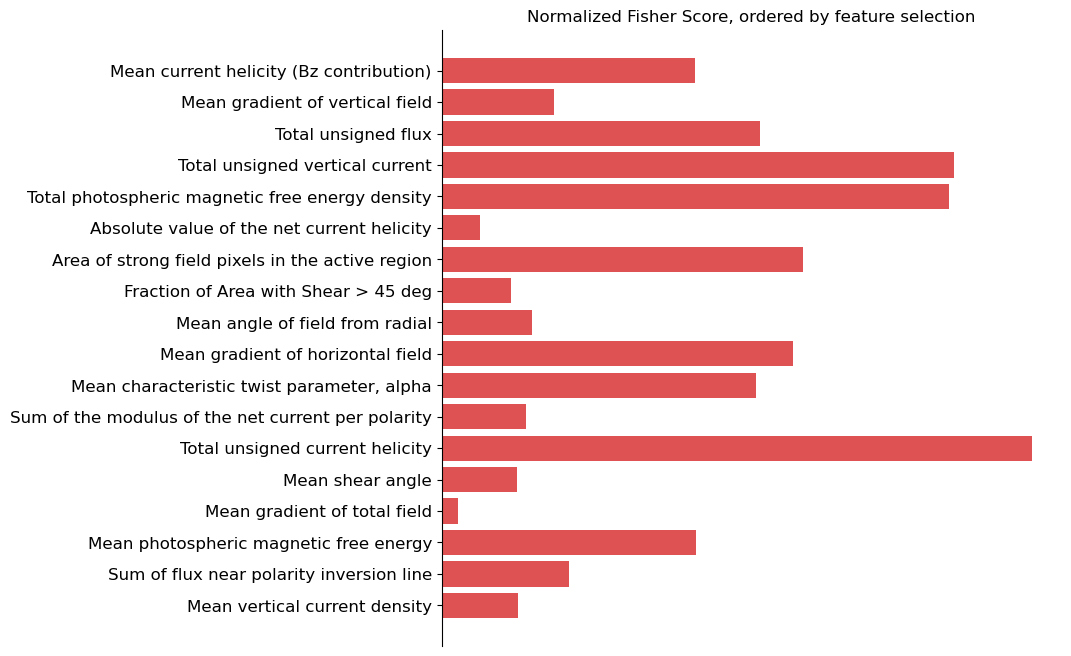

In [47]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(8, 8))

# Index of the features that are selected
label_of_features = []
for feature in range(18):
    label_of_features.append(best_combination.index(feature))

norder = np.argsort(label_of_features)[::-1]
norderedsharps = [sharps[i] for i in norder]
nscores = [selector.scores_[i] for i in norder]
y_pos2 = np.arange(18)
bars = plt.barh(y_pos2, nscores/np.max(scores), color='C3', alpha=0.8, height=0.8)
plt.yticks(y_pos2, norderedsharps, fontsize=12)
plt.xlabel('Normalized Fisher Score', fontsize=12)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

plt.title('Normalized Fisher Score, ordered by feature selection')

## Model-Agnostic "local" Explanations (Shapley values)

In [52]:
# Quick training
# import random split
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.25, random_state=42)


clf.fit(xtrain, ytrain)
TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
confusion_matrix_ = np.mean(confusion_matrix_k, axis=0)

print(confusion_matrix_)

[71.575 38.675 26.45  17.3  ]


In [57]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(clf.predict_proba, shap.kmeans(xdata, 200))
i = np.random.randint(0, xtest.shape[0])
shap_values = explainer.shap_values(xtest[i, :])
shap.force_plot(explainer.expected_value[0], shap_values[:, 0], xtest[i, :], feature_names=sharps)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [58]:
# Find the event in the metadata:
index_event = np.where(np.all(xdata == xtest[i, :], axis=1))[0][0]
print("The event was a", mdata[index_event][2], "class event, in the AR number", mdata[index_event][1], "at time", mdata[index_event][3], "with a CME associated" if ydata[index_event] == 1 else "with no CME associated")

The event was a M3.9 class event, in the AR number 12976 at time 2022.04.01_13:55_TAI with a CME associated


# Using the predictor to analyze new observations

In [94]:
student_index = 0

my_features = selected_features[student_index]
my_metadata = selected_metadata[student_index]

# Now it your turn to investigate your AR:
print("Investigating NOAA Active Region", my_metadata[1], "(HARPNUM", my_metadata[0], "),\n which produced a", my_metadata[2], "class flare on", my_metadata[3], ".")

# How do I know if this is a positive or negative class example? As this set does not belong 
# to the full dataset, we need to check it manually! Good luck with your analysis!



###### TO REMOVE BEFORE THE LECTURE ######



Investigating NOAA Active Region 13499 (HARPNUM 10409 ),
 which produced a M1.1 class flare on 2023.11.23_09:33_TAI .


In [108]:
import datetime

for ii in range(selected_metadata.shape[0]):
    print("Event at AR", selected_metadata[ii,1], selected_metadata[ii,2], (datetime.datetime.strptime(selected_metadata[ii,3], '%Y.%m.%d_%H:%M_TAI') + datetime.timedelta(hours=timedelayvariable)).strftime('%Y-%m-%dT%H:%M:%S'))

Event at AR 13499 M1.1 2023-11-24T09:33:00
Event at AR 13363 M2.9 2023-07-15T07:41:00
Event at AR 12644 M4.4 2017-04-01T21:48:00
Event at AR 13165 M4.5 2022-12-14T22:06:00
Event at AR 11430 X1.3 2012-03-07T01:14:00
Event at AR 13561 M4.3 2024-01-23T16:40:00
Event at AR 13514 X2.8 2023-12-14T17:02:00
Event at AR 12860 M4.7 2021-08-28T06:11:00
Event at AR 13331 M2.5 2023-06-09T17:11:00
Event at AR 13435 M8.2 2023-09-20T14:19:00
Event at AR 13386 M1.9 2023-08-04T04:24:00
Event at AR 13296 M2.1 2023-05-05T08:01:00
Event at AR 12403 M1.4 2015-08-21T09:48:00
Event at AR 13561 M1.0 2024-01-23T13:08:00
Event at AR 12297 M5.8 2015-03-09T23:53:00
Event at AR 12205 M2.0 2014-11-07T04:25:00
Event at AR 13336 M2.5 2023-06-18T13:53:00
Event at AR 12280 M2.4 2015-02-09T23:35:00
Event at AR 12673 M7.3 2017-09-07T10:15:00
Event at AR 13294 M1.8 2023-05-11T18:29:00
Event at AR 13152 M1.0 2022-12-01T07:21:00
Event at AR 13514 M6.3 2023-12-15T07:15:00
Event at AR 12871 M2.8 2021-09-23T04:42:00
Event at AR